In [50]:
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [51]:
import pandas as pd

In [52]:
import numpy as np

In [191]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [54]:
import torch
from sentence_transformers import SentenceTransformer
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Model is loaded on:", model.device)

/Users/bensmus/Desktop/Projects/AG_news_classify/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model is loaded on: mps:0


In [55]:
filename = 'AG_news_dataset/train.csv'
df = pd.read_csv(filename)
descriptions = np.array(df['Description'])
categories = np.array(df['Class Index'] - 1) # This -1 is CRUCIAL because classes must be 0...N-1 where N is number of classes.
descriptions, categories = shuffle(descriptions, categories, random_state=0)


In [56]:
embeddings = model.encode(descriptions)

In [8]:
# pca = PCA(n_components=50)
# embeddings = pca.fit_transform(embeddings)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(embeddings, categories, test_size=0.2, random_state=42)

In [243]:
inputs = tf.keras.Input(shape=(384,))
x = layers.Dropout(0.2)(inputs)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(150, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dense(50, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 200)            │        77,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,504 (498.06 KB)

 Trainable params: 127,504 (498.06 KB)

 Non-trainable params: 0 (0.00 B)

In [244]:
model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [245]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8500 - loss: 0.4289 - val_accuracy: 0.9001 - val_loss: 0.2896
Epoch 2/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8956 - loss: 0.3027 - val_accuracy: 0.9076 - val_loss: 0.2709
Epoch 3/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9052 - loss: 0.2716 - val_accuracy: 0.9099 - val_loss: 0.2634
Epoch 4/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9107 - loss: 0.2540 - val_accuracy: 0.9125 - val_loss: 0.2600
Epoch 5/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9143 - loss: 0.2398 - val_accuracy: 0.9114 - val_loss: 0.2570
Epoch 6/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9192 - loss: 0.2290 - val_accuracy: 0.9107 - val_loss: 0.2584
Epoch 7/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9233 - loss: 0.2178 - val_accuracy: 0.9122 - val_loss: 0.2570
Epoch 8/100
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9253 - loss: 0

In [246]:
y_val_predict_probs = model.predict(X_val)

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


In [247]:
y_val_predict = np.argmax(y_val_predict_probs, axis=1)

In [248]:
print('val accuracy', sum(y_val_predict == y_val) / len(y_val))

val accuracy 0.911125


In [249]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']

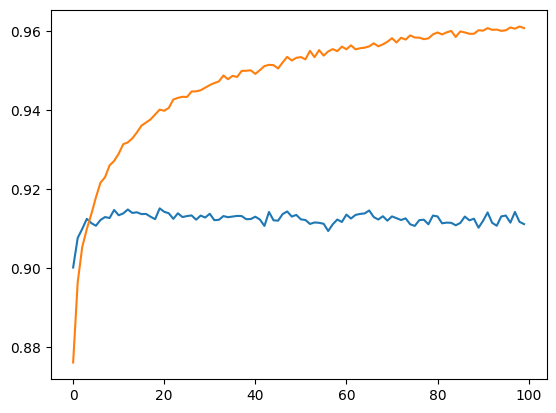

In [250]:
import  matplotlib.pyplot as plt
plt.plot(val_accuracy)
plt.plot(train_accuracy)